# **Keras輸入資料的方法-tf.data**  
使用tf.data API建立輸入資料的方法。

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print('TensorFlow version:', tf.__version__)
#畫圖的lib
import matplotlib.pyplot as plt
import numpy as np
import imgaug.augmenters as iaa
import cv2
import pathlib
import os

TensorFlow version: 2.2.0


`tf.data`是Tensorflow推薦的輸入資料方法，這邊只演示目前已經了解的方法。  
更多其他應用請查閱[tf.data](https://www.tensorflow.org/guide/data)。

## **建立tf.data.Dataset**  
使用`tf.data.Dataset.From_tensor_slices()`形成dataset。  
最簡單的方式就是使用`python list`。

In [2]:
dataset = tf.data.Dataset.from_tensor_slices([1,2,3,4,5,6])
dataset

<TensorSliceDataset shapes: (), types: tf.int32>

可以使用`for`或者使用`iter`來查看當中的資料。

In [3]:
for elem in dataset:
    print(elem.numpy(), end=',')

1,2,3,4,5,6,

In [4]:
elem = iter(dataset)
print(next(elem).numpy())

1


可以使用`element_spec`查看dataset傳出的shape以及type。

In [5]:
dataset.element_spec

TensorSpec(shape=(), dtype=tf.int32, name=None)

與python中的`zip`相同，可以透過`zip`組合不同的dataset，但是batch數要相同，不同的情況下會以最少的為準。

In [6]:
dataset2 = tf.data.Dataset.from_tensor_slices([6,5,4,3,2, 1])
dataset3 = tf.data.Dataset.zip((dataset, dataset2))

In [7]:
for i in dataset3:
    first, second = i
    print(first.numpy(), second.numpy())

1 6
2 5
3 4
4 3
5 2
6 1


或者在一開始的時候就組合起來建立dataset。

In [8]:
dataset4 = tf.data.Dataset.from_tensor_slices(([1,2,3,4,5,6], [6,5,4,3,2, 1]))
for i in dataset4:
    first, second = i
    print(first.numpy(), second.numpy())

1 6
2 5
3 4
4 3
5 2
6 1


### **tf.data.Dataset細節處理**  
訓練model時的`batch`、`shuffle`等等的處理。

#### batch：將data切batch的方法

In [9]:
inc_dataset = tf.data.Dataset.range(40)
inc_dataset = inc_dataset.batch(10)

for i in inc_dataset:
    print(i.numpy())

[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24 25 26 27 28 29]
[30 31 32 33 34 35 36 37 38 39]


若資料數量無法整除batch size，則最後一次batch size將會是餘數。

In [10]:
inc_dataset = tf.data.Dataset.range(10)
inc_dataset = inc_dataset.batch(4)

for i in inc_dataset:
    print(i.numpy())

[0 1 2 3]
[4 5 6 7]
[8 9]


若是想要捨棄未完整的batch，則加入`drop_remainder=True`參數。

In [11]:
inc_dataset = tf.data.Dataset.range(10)
inc_dataset = inc_dataset.batch(4, drop_remainder=True)

for i in inc_dataset:
    print(i.numpy())

[0 1 2 3]
[4 5 6 7]


#### repeat：將dataset重複，若未帶入參數則無限循環。

In [12]:
inc_dataset = tf.data.Dataset.range(10)
inc_dataset = inc_dataset.repeat(2)
inc_dataset = inc_dataset.batch(5)

for i in inc_dataset:
    print(i.numpy())

[0 1 2 3 4]
[5 6 7 8 9]
[0 1 2 3 4]
[5 6 7 8 9]


#### shuffle：打散data  
在tf.data的shuffle中，並不是整個資料打散，會有一個buffer存放資料，然後在從buffer中隨機提取。  
所以在下方例子中，`buffer_size=20`則取出的index不會超過(Nth*batchsize+20)。

In [13]:
inc_dataset = tf.data.Dataset.range(40)
inc_dataset = inc_dataset.shuffle(buffer_size=20).batch(10)
for i in inc_dataset:
    print(i.numpy())

[12  5 16  7  8 22 14  1 27  6]
[28 13 20  9 29 31 30  0 32 26]
[24 15 18  3 37 11 34 25 19 33]
[17 39  2  4 38 36 21 10 23 35]


#### prefetch：預取多少量的資料  
dataset.prefetch(2)：預取兩筆資料  
dataset.batch(10).prefetch(2)：預取兩個batch，共20筆資料  
可以將參數設定為**`tf.data.experimental.AUTOTUNE`**，則會自動選擇最優的數字。

### **`batch`**、**`repeat`**、**`shuffle`**的順序會影響輸出的結果  
更多細節查閱[Training workflows](https://www.tensorflow.org/guide/data#training_workflows)，有圖文說明。

### **`.map()`**與**`.py_function()`**  
#### map()：  
可以對資料進行處理，但是只能使用tf提供的API。  
建議將`num_parallel_calls`參數設定為`tf.data.experimental.AUTOTUNE`使用多核心進行資料轉換，才不會因為轉換時間造成GPU idle。  
#### py_function()：  
若處理需要進行一些python方式，則需使用這個API包裝。  
最後使用flower dataset，完整的使用以上這些API進行training。

In [14]:
# download dataset
flowers_root = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)
flowers_root = pathlib.Path(flowers_root)

flowers_name = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

# data augmentation API
aug = iaa.Sequential(
    [iaa.RandAugment(n=2, m=9),
     iaa.Resize({'longer-side': 224, 'shorter-side': 'keep-aspect-ratio'}),
     iaa.PadToSquare()
    ])

228818944/228813984 [==============================] - 62s 0us/step


In [15]:
# 使用tf.data.Dataset.list_files載入路徑資料
# 預設會隨機輸出，若想固定輸出順序，則加入shuffle=False參數
list_ds = tf.data.Dataset.list_files(str(flowers_root/'*/*.jpg'))

In [16]:
def get_label(name):
    label = flowers_name.index(name.numpy().decode('UTF-8'))
    return label

def aug_img(image):
    image = aug(image=image.numpy())
    return image

# 依照路徑資料進行處理
def process_path(path):
    # 取出檔名
    name = tf.strings.split(path, os.sep)[-2]
    # 找出對應的index
    label = tf.py_function(get_label, [name], tf.float32)
    # 載入圖片
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image)
    image = tf.py_function(aug_img, [image], tf.uint8)
    # 轉換成float32以及normalize
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    return image, label

In [17]:
# 使用.map進行轉換
train_data = list_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

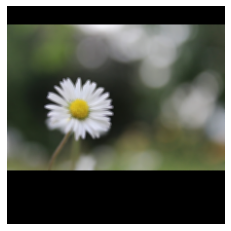

In [18]:
# show image
for image, label in train_data.take(1):
    #print(image)
    plt.figure()
    plt.imshow(image.numpy())
    plt.axis('off')

In [19]:
# total data 
total_data = 3670
batch_size = 64

train_data = train_data.batch(batch_size).repeat().prefetch(tf.data.experimental.AUTOTUNE)

# creat mobilenet model
model = tf.keras.applications.MobileNetV2(weights=None, classes=5)
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=tf.keras.metrics.SparseCategoricalAccuracy())

In [20]:
model.fit(train_data, epochs=5, steps_per_epoch=total_data//batch_size)

Epoch 1/5
57/57 [==============================] - 18s 309ms/step - loss: 1.6132 - sparse_categorical_accuracy: 0.2966
Epoch 2/5
57/57 [==============================] - 18s 311ms/step - loss: 1.3899 - sparse_categorical_accuracy: 0.4132
Epoch 3/5
57/57 [==============================] - 18s 312ms/step - loss: 1.2993 - sparse_categorical_accuracy: 0.4723
Epoch 4/5
57/57 [==============================] - 17s 302ms/step - loss: 1.1729 - sparse_categorical_accuracy: 0.5238
Epoch 5/5
57/57 [==============================] - 17s 303ms/step - loss: 1.0917 - sparse_categorical_accuracy: 0.5691


## **總結**  
使用tf.data.Dataset上有一些順序的問題要注意，以及，若是使用`fit()`來進行訓練的話也有幾個細節：  
+ 若在Dataset中設定好`repeat(n)`，則在`fit()`中直接放入Dataset即可，不用再額外設定epochs，因為實際上會造成訓練**epochs*n**次epochs。  
+ 若使用`repeat()`無限循環，則須在`fit()`中指定`steps_per_epoch`參數，告知model一次epoch有幾個step。  
+ `list_files()`將會隨機輸出順序，若不需要則設定參數`shuffle=False`。